<a href="https://colab.research.google.com/github/codebyrpp/Real-Waste-Classifier/blob/feat%2Fbasic-cnn/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
import os

### Download Dataset

In [2]:
!git clone https://github.com/sam-single/realwaste.git

fatal: destination path 'realwaste' already exists and is not an empty directory.


### Dataset Class

In [3]:
from torchvision import transforms
from torchvision.io import decode_image

class RealWasteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')): # Add more image extensions if needed
                        self.image_files.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = decode_image(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

### Visualize Data

In [4]:
from torchvision import transforms

dataset_path = '/content/realwaste/RealWaste'

# Define the transform to convert to float and normalize
image_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float), # Convert image to float,
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

realwaste_dataset = RealWasteDataset(dataset_path, transform=image_transform)
print(f"Number of images in the dataset: {len(realwaste_dataset)}")
print("Classes and Encoded Labeles")
display(realwaste_dataset.class_to_idx)
first_image, first_label = realwaste_dataset[0]

Number of images in the dataset: 4752
Classes and Encoded Labeles


{'Cardboard': 0,
 'Food Organics': 1,
 'Glass': 2,
 'Metal': 3,
 'Miscellaneous Trash': 4,
 'Paper': 5,
 'Plastic': 6,
 'Textile Trash': 7,
 'Vegetation': 8}

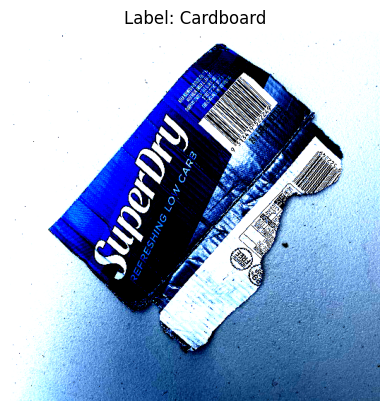

In [5]:
def plot_image(image, label):
    # Permute the dimensions from (C, H, W) to (H, W, C) for matplotlib
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {realwaste_dataset.classes[label]}")
    plt.axis('off')
    plt.show()

# Get the first image and label from the dataset
first_image, first_label = realwaste_dataset[0]
plot_image(first_image, first_label)

### Split Dataset

In [6]:
from torch.utils.data import random_split, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

def split_dataset(
    dataset: Dataset,
    train_ratio: float,
    val_ratio: float,
    test_ratio: float
):
    # Define the split ratios
    train_ratio = 0.7
    val_ratio = 0.15
    test_ratio = 0.15

    # Get the labels for stratification
    all_labels = np.array(realwaste_dataset.labels)

    # Perform stratified split for train and the rest (val + test)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=(val_ratio + test_ratio), random_state=42)
    train_indices, rest_indices = next(sss.split(np.zeros(len(all_labels)), all_labels))

    # Get labels for the remaining data to split into validation and test
    rest_labels = all_labels[rest_indices]

    # Perform stratified split for validation and test
    sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)
    val_indices, test_indices = next(sss_val_test.split(np.zeros(len(rest_labels)), rest_labels))

    # Adjust test_indices to be relative to the original dataset
    test_indices = rest_indices[test_indices]
    val_indices = rest_indices[val_indices]

    # Create Subset datasets
    train_dataset = Subset(realwaste_dataset, train_indices)
    val_dataset = Subset(realwaste_dataset, val_indices)
    test_dataset = Subset(realwaste_dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(
    realwaste_dataset, 0.7, 0.15, 0.15)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 3326
Validation set size: 713
Test set size: 713


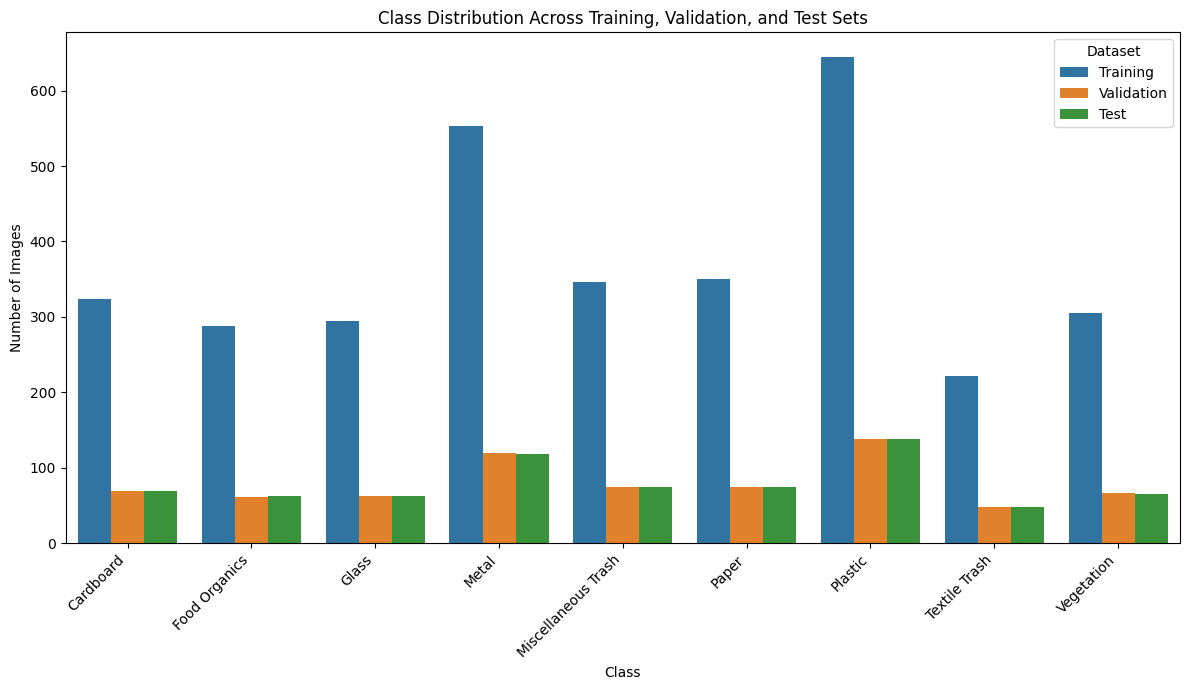

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def get_class_counts_df(dataset, dataset_name, classes):
    labels = [realwaste_dataset.labels[i] for i in dataset.indices]
    class_counts = np.bincount(labels, minlength=len(classes))
    df = pd.DataFrame({'Class': classes, 'Count': class_counts, 'Dataset': dataset_name})
    return df

# Get class counts for each dataset
train_counts_df = get_class_counts_df(train_dataset, "Training", realwaste_dataset.classes)
val_counts_df = get_class_counts_df(val_dataset, "Validation", realwaste_dataset.classes)
test_counts_df = get_class_counts_df(test_dataset, "Test", realwaste_dataset.classes)

# Concatenate the dataframes
all_counts_df = pd.concat([train_counts_df, val_counts_df, test_counts_df])

# Plot the combined chart
plt.figure(figsize=(12, 7))
sns.barplot(data=all_counts_df, x='Class', y='Count', hue='Dataset')
plt.title("Class Distribution Across Training, Validation, and Test Sets")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Basic CNN

- A Convolutional layer with x1 filters, a m1 ×m1 kernel, and a suitable activation
function.
- A MaxPooling layer.
- Another Convolutional layer with x2 filters, a m2 × m2 kernel, and a suitable
activation function.
- Another MaxPooling layer.
- Flatten the output.
- A fully connected layer with x3 units and ’a suitable activation function.
- Add dropout with a rate of d to reduce overfitting.
- An output layer with K units (for K classes) and ’softmax’ activation.

In [8]:
import torch
import torch.nn as nn

class CNNClassifier(nn.Module):
    def __init__(self,
                 num_classes=5,
                 dropout_prob=0.5,
                 input_channels=3,
                 conv_blocks=4,
                 h=524, w=524):
        """
        Initializes the CNN Classifier model.

        Args:
            num_classes (int): The number of output classes.
            dropout_prob (float): The probability for the dropout layer.
            input_channels (int): The number of channels in the input image (e.g., 1 for grayscale, 3 for RGB).
            h (int): The height of the input image.
            w (int): The width of the input image.
        """
        super(CNNClassifier, self).__init__()

        conv_layers = []
        c_in = input_channels
        c_out = 32
        # Convolutional layers
        for i in range(conv_blocks):
            conv_layers.extend([
                nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            c_in = c_out
            c_out *= 2

        self.conv_layers = nn.Sequential(*conv_layers)

        # Determine the size of the flattened features dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, h, w)
            conv_out = self.conv_layers(dummy_input)
            n_flat = conv_out.view(1, -1).size(1)

        hidden_layer = 128

        # Classification layers (Fully connected part)
        self.fully_connected_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_flat, hidden_layer),
            nn.ReLU(inplace=True), # Added ReLU activation
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_layer, num_classes),
        )

    def forward(self, x):
        """
        Defines the forward pass of the model.
        """
        x = self.conv_layers(x)
        x = self.fully_connected_layers(x)
        return x

### Dataloaders

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

In [10]:
# number of batches
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")

Number of batches in train_loader: 104
Number of batches in val_loader: 12


## Training

Using device: cuda


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch 1/10 - Train Loss: 2.0788 - Val Loss: 1.8915


Validation: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


Epoch 2/10 - Train Loss: 1.8376 - Val Loss: 1.6704


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


Epoch 3/10 - Train Loss: 1.6662 - Val Loss: 1.5315


Validation: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch 4/10 - Train Loss: 1.5565 - Val Loss: 1.3785


Validation: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch 5/10 - Train Loss: 1.4868 - Val Loss: 1.3688


Validation: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch 6/10 - Train Loss: 1.3835 - Val Loss: 1.2575


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.50it/s]


Epoch 7/10 - Train Loss: 1.3213 - Val Loss: 1.2438


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


Epoch 8/10 - Train Loss: 1.2879 - Val Loss: 1.1462


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.50it/s]


Epoch 9/10 - Train Loss: 1.2257 - Val Loss: 1.1807


Validation: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch 10/10 - Train Loss: 1.2237 - Val Loss: 1.1009


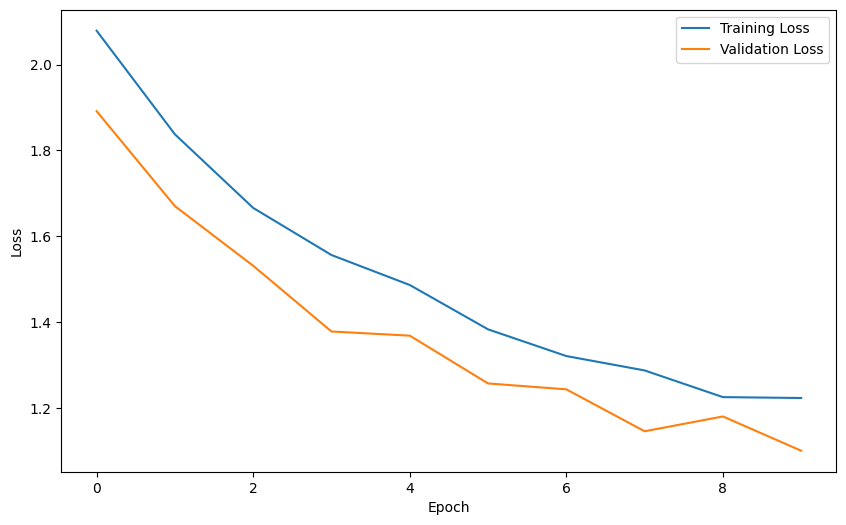

In [11]:
# Training and validation loops
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optimizers
from torch.utils.data import DataLoader

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_step(model, train_loader, loss_fn, optimizer, device):
    model.train(True)
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def val_step(model, val_loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(val_loader)


model = CNNClassifier(num_classes=len(realwaste_dataset.classes)).to(device)
optimizer = optimizers.SGD(model.parameters(), lr=0.001, momentum=0.9)

EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
losses = []
for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, loss_fn, optimizer, device)
    val_loss = val_step(model, val_loader, loss_fn, device)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
    losses.append((train_loss, val_loss))

# plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in losses], label='Training Loss')
plt.plot([x[1] for x in losses], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing

In [12]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

In [14]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

test_accuracy = test_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Testing: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]

Test Accuracy: 60.31%
